<a href="https://colab.research.google.com/github/keskinyasemin/Car-License-Plate-Recognition/blob/master/CatsAndDogsClassificationWithKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Preparing Data**

In [ ]:
import zipfile

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-08-28 22:29:32--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.220.124.196, 2600:1408:c400:188c::317f, 2600:1408:c400:1888::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.220.124.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M  65.0MB/s    in 8.8s    

2022-08-28 22:29:41 (89.6 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [ ]:
import os
os.remove('/tmp/PetImages/Dog/Thumbs.db')
os.remove('/tmp/PetImages/Cat/Thumbs.db')


In [ ]:
import cv2
import numpy as np

CLASSES = ['Cat','Dog']
data_path = '/tmp/PetImages/'

for i in CLASSES:

    curr_dir_path = data_path + i + '/'
    labels = os.listdir(curr_dir_path)
    
    for x in labels:
        #print(data_path + i + '/' + x)
        img = cv2.imread(data_path + i + '/' + x)
        try:
          res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
          cv2.imwrite(data_path + i + '/' + x, res)
        except:
          os.remove(data_path + i + '/' + x)

In [ ]:
from sklearn.model_selection import train_test_split

CLASSES = ['Cat','Dog']
data_path = '/tmp/PetImages/'

for i in CLASSES:
    
    curr_dir_path = data_path + i + '/'
    
    xtrain = labels = os.listdir(curr_dir_path)
    
    x, x_test, y, y_test = train_test_split(xtrain,labels,test_size=0.2,train_size=0.8)
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.25,train_size =0.75)
    
    for x in x_train:
        
        if (not os.path.exists(data_path+'train/' + i + '/')):
            os.makedirs(data_path+'train/' + i + '/')
            
        os.rename(data_path + i + '/' + x, data_path+'train/' + i + '/' + x)
        
    for x in x_test:
        
        if (not os.path.exists(data_path+'test/' + i + '/')):
            os.makedirs(data_path+'test/' + i + '/')
            
        os.rename(data_path + i + '/' + x, data_path+'test/' + i + '/' + x)
    
    for x in x_val:
        
        if (not os.path.exists(data_path+'validation/' + i + '/')):
            os.makedirs(data_path+'validation/' + i + '/')
            
        os.rename(data_path + i + '/' + x, data_path+'validation/' + i + '/' + x)

In [ ]:
os.rmdir('/tmp/PetImages/Cat')
os.rmdir('/tmp/PetImages/Dog')
print(os.listdir('/tmp/PetImages/'))

['test', 'train', 'validation']


In [ ]:
# !zip -r /tmp/PetImages.zip /tmp/PetImages
# from google.colab import files
# files.download("/tmp/PetImages.zip")

#**2. Model Training**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.utils.np_utils import to_categorical
from keras import applications
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
import tensorflow as tf
import datetime
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
#Tweakable
batch_size = 32
INIT_LR = 1e-4
# Directories
train_dir = '/tmp/PetImages/train'
val_dir = '/tmp/PetImages/validation/'
test_dir = '/tmp/PetImages/test/'
num_classes = 2

In [ ]:
image_gen = ImageDataGenerator(rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rescale=1/255, 
                               shear_range=0.2, 
                               zoom_range=0.2,
                               horizontal_flip=True, 
                               fill_mode='nearest'
                              )

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

In [ ]:
base_model = tf.keras.applications.MobileNet(weights='imagenet',include_top=False, input_tensor = Input(shape=(224, 224, 3)))
base_model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [ ]:
headModel = base_model.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(1024,activation='relu')(headModel)
headModel = Dense(1024,activation='relu')(headModel)
headModel = Dense(512,activation='relu')(headModel)
headModel = Dropout(0.09)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
model = Model(inputs=base_model.input, outputs=headModel)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [ ]:
print("[INFO] compiling model...")
opt = tf.keras.optimizers.Adam(lr=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
checkpoint_callback = ModelCheckpoint(
                        "dogscats.h5",
                        monitor='val_accuracy',
                        verbose=1,
                        save_best_only=True,
                        mode='max')
callbacklist=[checkpoint_callback]

[INFO] compiling model...


In [ ]:
train_image_gen = image_gen.flow_from_directory(train_dir,
                                               target_size=(224,224),
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle = True)

Found 14967 images belonging to 2 classes.


In [ ]:
val_image_gen = image_gen.flow_from_directory(val_dir,
                                              target_size=(224,224),
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle = True)

Found 4989 images belonging to 2 classes.


In [ ]:
hist = model.fit_generator(train_image_gen,epochs=5,
                           steps_per_epoch=50,
                           validation_data=val_image_gen,
                           validation_steps=25,
                           callbacks=callbacklist)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/5
50/50 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9606
Epoch 1: val_accuracy improved from -inf to 0.97750, saving model to dogscats.h5
50/50 [==============================] - 344s 7s/step - loss: 0.0928 - accuracy: 0.9606 - val_loss: 0.0604 - val_accuracy: 0.9775
Epoch 2/5
50/50 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.9688
Epoch 2: val_accuracy improved from 0.97750 to 0.98000, saving model to dogscats.h5
50/50 [==============================] - 348s 7s/step - loss: 0.0835 - accuracy: 0.9688 - val_loss: 0.0502 - val_accuracy: 0.9800
Epoch 3/5
50/50 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.9762
Epoch 3: val_accuracy did not improve from 0.98000
50/50 [==============================] - 346s 7s/step - loss: 0.0618 - accuracy: 0.9762 - val_loss: 0.0658 - val_accuracy: 0.9725
Epoch 4/5
50/50 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9750
Epoch 4: val_accuracy 

In [ ]:
#model.save('./catsdogs.h5')

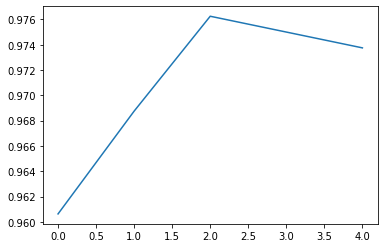

In [ ]:
plt.plot(hist.history['accuracy'])

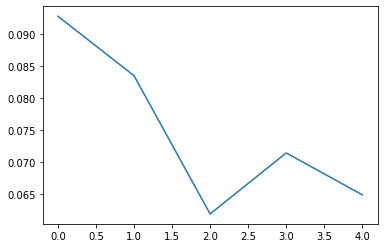

In [ ]:
plt.plot(hist.history['loss'])

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_batches = test_gen.flow_from_directory(test_dir,
                                        target_size=(224,224),
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle = False)

Found 4990 images belonging to 2 classes.


In [ ]:
test_loss, test_acc = model.evaluate_generator(test_batches, verbose=1,steps=150)
print('test acc:', test_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


150/150 [==============================] - 160s 1s/step - loss: 0.0455 - accuracy: 0.9804
test acc: 0.9804166555404663


In [ ]:
print('test loss:', test_loss)

test loss: 0.04550846293568611
